# 2 Convolutional Neural Network

In [346]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.utils import make_grid
from torchtoolbox.tools import summary
import matplotlib.pyplot as plt
import zipfile
import numpy as np
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

# def zip_list(file_path):
#     zf = zipfile.ZipFile(file_path, 'r')
#     zf.extractall()

# if __name__ == '__main__':
#     file_path = 'train.zip'
#     zip_list(file_path)

In [347]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

device = get_default_device()
# print(device)
# !nvidia-smi

In [348]:
import cv2
from PIL import Image

train_img = np.zeros((10,200,32,32,3))
test_img = np.zeros((10,40,32,32,3))

path = os.listdir("./train/")
path.sort()
path_train_transport = []
path_test_transport = []

for i in path:
    path_train_transport.append(os.listdir("./train/" + i + "/"))
    path_test_transport.append(os.listdir("./test/" + i + "/"))

# print(len(path_train_transport[0]))
# print(path_train_transport)
# print(len(path_test_transport[0]))
# print(path_test_transport)
# print(path)

for i in range(len(train_img)):
    for j in range(len(train_img[0])):
        train_img[i,j] = cv2.imread("./train/" + path[i] + "/" + path_train_transport[i][j])
    for k in range(len(test_img[0])):    
        test_img[i,k] = cv2.imread("./test/" + path[i] + "/" + path_test_transport[i][k])

""" Data Processing """
# Data transforms (normalization & data augmentation)
train_img = train_img.reshape(2000, 32, 32, 3)
test_img = test_img.reshape(400, 32, 32, 3)
train_img = train_img / 255.0
test_img = test_img / 255.0

# stats = ((train_img[:, :, :, 0].mean(), train_img[:, :, :, 1].mean(), train_img[:, :, :, 2].mean()), 
#          (train_img[:, :, :, 0].std(), train_img[:, :, :, 0].std(), train_img[:, :, :, 0].std()))

# train_tfms = tt.Compose([
#     tt.transforms.RandomCrop(32, padding = 4),
#     tt.transforms.RandomHorizontalFlip(),
#     tt.transforms.ToTensor(),
#     tt.transforms.Normalize(mean = stats[0], std = stats[1])])

# test_tfms = tt.Compose([
#     tt.transforms.ToTensor(),
#     tt.transforms.Normalize(mean = stats[0], std = stats[1])])

# train_img = Image.fromarray(np.uint8(train_img[0]))
# test_img = Image.fromarray(np.uint8(test_img[:])) 
# train_img = train_tfms(train_img)
# test_img = train_tfms(test_img)
onehot_train = np.arange(0,2000,1) // 200
onehot_test = np.arange(0,400,1) // 40
train_label = np.eye(10)[onehot_train]
test_label = np.eye(10)[onehot_test]
train_label = torch.Tensor(train_label)
test_label = torch.Tensor(test_label)
train_label = to_device(train_label, device)
test_label = to_device(test_label, device)

In [349]:
class DeviceDataLoader():
    """ Move data to a device """
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """ Yield a batch of data after moving it to device """
        for data in self.dl:
            yield to_device(data, self.device)

    def __len__(self):
        """ Number of Batches """
        return len(self.dl)

class Dataset(torch.utils.data.Dataset):
    def __init__(self, dataset, label) -> None:
        super().__init__()
        self.dataset = dataset
        self.label = label

    def __getitem__(self, idx):
        return torch.Tensor(self.dataset[idx]), torch.Tensor(self.label[idx])

    def __len__(self):
        return len(self.dataset)

train_img = torch.Tensor(train_img)
test_img = torch.Tensor(test_img)
train_dl = train_img.permute(0, 3, 1, 2)
test_dl = test_img.permute(0, 3, 1, 2)
train_dl = to_device(train_dl, device)
test_dl = to_device(test_dl, device)
train_dl = DataLoader(dataset = Dataset(train_dl,train_label), batch_size = 128, shuffle = True)
test_dl = DataLoader(dataset = Dataset(test_dl,test_label), batch_size = 128, shuffle = True)

In [350]:
""" Model """
def accuracy(pred, label):
    _, preds = torch.max(pred, dim = 1)
    _, labels = torch.max(label, dim = 1)
    return torch.sum(preds == labels) / len(preds)

def convolution_block(in_channel, out_channel, kernel_size, stride, padding):
    layers = [nn.Conv2d(in_channel, out_channel, kernel_size = kernel_size, stride = stride, padding = padding),
              nn.BatchNorm2d(out_channel),
              nn.ReLU(inplace = True)]
    return nn.Sequential(*layers)

class ImageClassificationBase(nn.Module):
    def train_step(self, batch):
        data, label = batch
        output = self.forward(data)
        # print("train",output)
        # print("train_label",label)
        loss = F.cross_entropy(output, label)
        acc = accuracy(output, label)
        return {"train_loss": loss, "train_acc": acc}

    def test_step(self, batch):
        data, label = batch
        output = self.forward(data)
        # print("test", output)
        # print("test_label",label)
        loss = F.cross_entropy(output, label)
        acc = accuracy(output, label)
        return {"test_loss": loss, "test_acc": acc}

    def test_epoch_end(self, train_output, test_output):
        train_losses = [x["train_loss"] for x in train_output]
        epoch_loss = torch.stack(train_losses).mean()           # Combine Train Loss
        train_accs = [x["train_acc"] for x in train_output]
        epoch_acc = torch.stack(train_accs).mean()            # Combine Train Accuracy

        test_losses = [x["test_loss"] for x in test_output]
        test_epoch_loss = torch.stack(test_losses).mean()      # Combine Test Loss
        test_accs = [x["test_acc"] for x in test_output]
        test_epoch_acc = torch.stack(test_accs).mean()       # Combine Test Accuracy

        return {"train_loss": epoch_loss, "train_acc": epoch_acc}, {"test_loss": test_epoch_loss, "test_acc": test_epoch_acc}

    def epoch_end(self, epoch, train_result, test_result):
        # print("Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}".format(
        #       epoch + 1, train_result["train_loss"].item(), train_result["train_acc"].item()))
        # print("Epoch [{}], test_loss: {:.4f}, test_acc: {:.4f}".format(
        #       epoch + 1, test_result["test_loss"].item(), test_result["test_acc"].item()))
        pass
        
class Inception(nn.Module):
    def __init__(self, input_channel, n1x1, n3x3_reduce, n3x3, n5x5_reduce, n5x5, pool_proj):
        super().__init__()

        self.b1 = convolution_block(input_channel, n1x1, kernel_size = 1, stride = 1, padding = 0)

        self.b2 = nn.Sequential(convolution_block(input_channel, n3x3_reduce, kernel_size = 1, stride = 1, padding = 0),
                                convolution_block(n3x3_reduce, n3x3, kernel_size = 3, stride = 1, padding = 1))

        self.b3 = nn.Sequential(convolution_block(input_channel, n5x5_reduce, kernel_size = 1, stride = 1, padding = 0),
                                convolution_block(n5x5_reduce, n5x5, kernel_size = 3, stride = 1, padding = 1),
                                convolution_block(n5x5, n5x5, kernel_size = 3, stride = 1, padding = 1))

        self.b4 = nn.Sequential(nn.MaxPool2d(3, stride = 1, padding = 1),
                                convolution_block(input_channel, pool_proj, kernel_size = 1, stride = 1, padding = 0))

    def forward(self, x):
        return torch.cat([self.b1(x),  self.b2(x), self.b3(x), self.b4(x)], dim = 1)

class GoogleNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.relu = nn.ReLU(inplace = True)
        self.conv_1 = nn.Conv2d(3, 64, kernel_size = 3, padding = 1, bias = False)
        self.norm_1 = nn.BatchNorm2d(64)
        self.conv_2 = nn.Conv2d(64, 64, kernel_size = 3, padding = 1, bias = False)
        self.norm_2 = nn.BatchNorm2d(64)
        self.conv_3 = nn.Conv2d(64, 192, kernel_size = 3, padding = 1, bias = False)
        self.norm_3 = nn.BatchNorm2d(192)
        self.conv_4 = nn.Conv2d(192, 384, kernel_size = 3, padding = 1, bias = False)
        self.norm_4 = nn.BatchNorm2d(384)

        self.A1 = Inception(192, 64, 96, 128, 16, 32, 32)
        self.A2 = Inception(256, 128, 128, 192, 32, 96, 64)
        self.A3 = Inception(480, 192, 96, 208, 16, 48, 64)
        self.A4 = Inception(512, 160, 112, 224, 24, 64, 64)
        self.A5 = Inception(512, 128, 128, 256, 24, 64, 64)
        self.A6 = Inception(512, 112, 144, 288, 32, 64, 64)
        self.A7 = Inception(528, 256, 160, 320, 32, 128, 128)
        self.A8 = Inception(832, 256, 160, 320, 32, 128, 128)
        self.A9 = Inception(832, 384, 192, 384, 48, 128, 128)
        self.maxpool = nn.MaxPool2d(3, stride = 2, padding = 1)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p = 0.4)
        self.fc = nn.Linear(384,10)

    def forward(self, data):
        data = self.conv_1(data)
        data = self.norm_1(data)
        data = self.relu(data)
        data = self.maxpool(data)
        data = self.conv_2(data)
        data = self.norm_2(data)
        data = self.relu(data)
        data = self.maxpool(data)
        data = self.conv_3(data)
        data = self.norm_3(data)
        data = self.relu(data)
        data = self.maxpool(data)
        data = self.conv_4(data)
        data = self.norm_4(data)
        data = self.relu(data)
        

        # data = self.maxpool(data)
        # data = self.A1(data)
        # data = self.A2(data)
        # data = self.maxpool(data)

        # data = self.A3(data)
        # data = self.A4(data)
        # data = self.A5(data)
        # data = self.A6(data)
        # data = self.A7(data)
        # data = self.maxpool(data)

        # data = self.A8(data)
        # data = self.A9(data)
        data = self.avgpool(data)
        data = self.dropout(data)
        data = data.view(data.size()[0], -1)
        data = self.fc(data)
        return data

In [351]:
Identity = True
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride = 1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size = 3, stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size = 1, stride = stride, bias = False),
                nn.BatchNorm2d(self.expansion * planes))

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if Identity:
            out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(ImageClassificationBase):
    def __init__(self, block, num_blocks, num_classes = 10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64,  num_blocks[0], stride = 1)
        self.layer2 = self._make_layer(block, 192, num_blocks[1], stride = 2)
        self.layer3 = self._make_layer(block, 384, num_blocks[2], stride = 2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride = 2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

# def ResNet18_Identity():
#     return ResNet(Identity_Block, [2, 2, 2, 2])

In [352]:
""" Set Confict """
Model = to_device(GoogleNet(), device)
epochs = 100
max_lr = 0.0008
train_best_acc = 0.
test_best_acc = 0.
optimizer = torch.optim.SGD(params = Model.parameters(), lr = max_lr, momentum = 0.9, weight_decay = 5e-4)
train_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = epochs // 2)

def evaluate(model, train, test):
    with torch.no_grad():
        model.eval()
        train_outputs = [model.train_step(batch) for batch in train]
        # print(train_outputs)
        test_outputs = [model.test_step(batch) for batch in test]
    return model.test_epoch_end(train_outputs, test_outputs)

""" Training """
def Train(epochs, Model, train_dl, test_dl, opt, epoch_array = [], train_loss_array = [], test_loss_array = [], train_best_acc = 0., test_best_acc = 0.):
    torch.cuda.empty_cache() 
    train_history = []
    test_history = []
    count = 0
    for epoch in range(epochs):
        """ Training """
        Model.train()
        loss_sum = 0.
        loss_acc = 0.
        train_num = 0
        for batch in train_dl:
            opt.zero_grad()
            loss = Model.train_step(batch)
            # print("Epoch: ", epoch + 1)
            # print("Iteration: ", count + 1)
            # print("loss: ", loss["train_loss"].item())
            # print("acc:  ", loss["train_acc"].item())
            # print("------------------------------")
            loss_sum += loss["train_loss"].item()
            loss_acc += loss["train_acc"].item()
            train_num += 1
            loss["train_loss"].backward()
            opt.step()
            count += 1
            # print("Train Epoch: {}, Loss: {:.6f}".format(epoch,  loss.item()))

        """ Test """
        # print("Train loss: ", (loss_sum / train_num).item())
        train_loss_array.append(loss_sum / train_num)
        test_loss_array.append(loss_acc / train_num)
        epoch_array.append(epoch + 1)
        train_result, test_result = evaluate(Model, train_dl, test_dl)
        Model.epoch_end(epoch, train_result, test_result)
        if train_best_acc < train_result["train_acc"]:
            train_best_acc = train_result["train_acc"]
        # print("Epoch: ",epoch + 1)
        if epoch == 99:
            print("Best train acc: ", train_best_acc.item())
        if test_best_acc < test_result["test_acc"]:
            test_best_acc = test_result["test_acc"]
        if epoch == 99:
            print("Best test acc: ", test_best_acc.item())
        train_history.append(train_result)
        test_history.append(test_result)
        # train_scheduler.step()
    return train_history, test_history

Best train acc:  0.96484375
Best test acc:  0.564453125


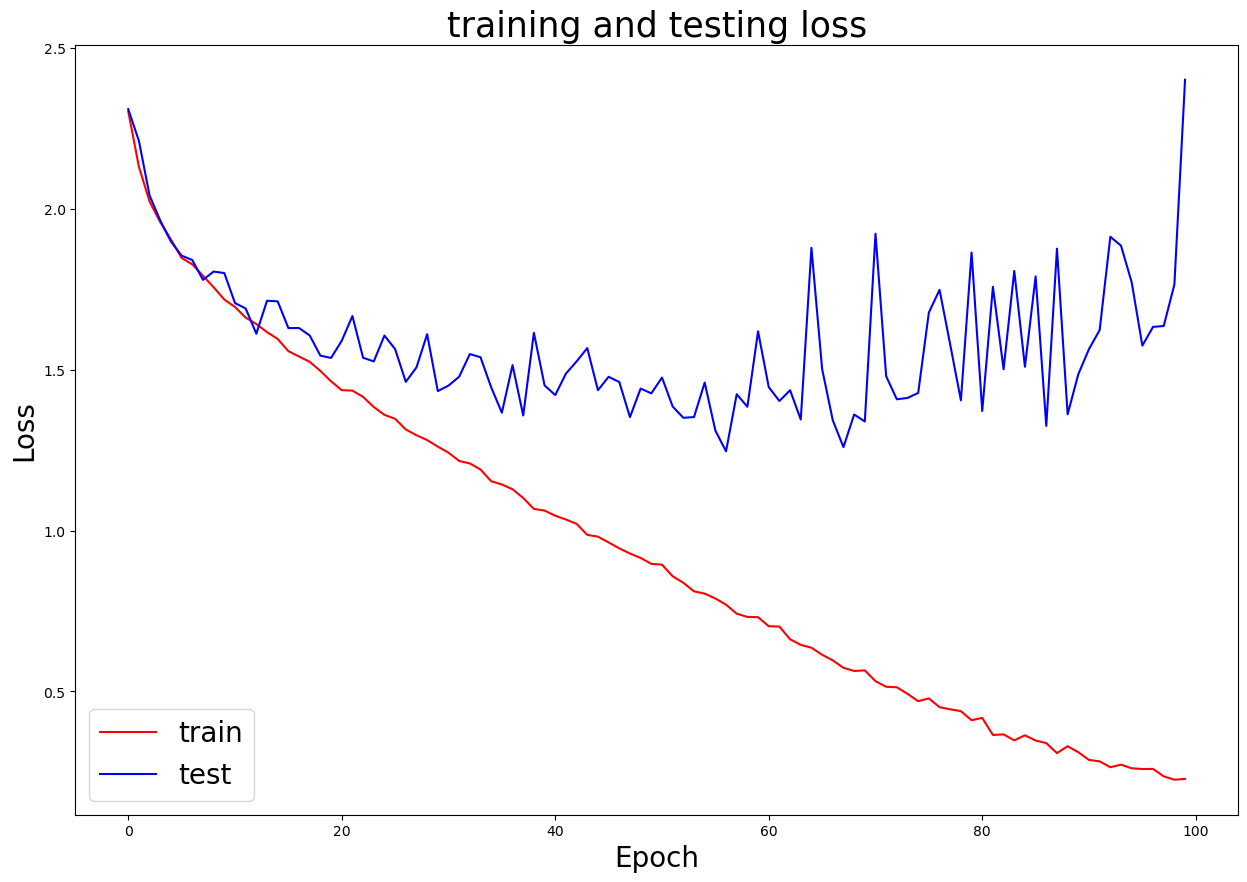

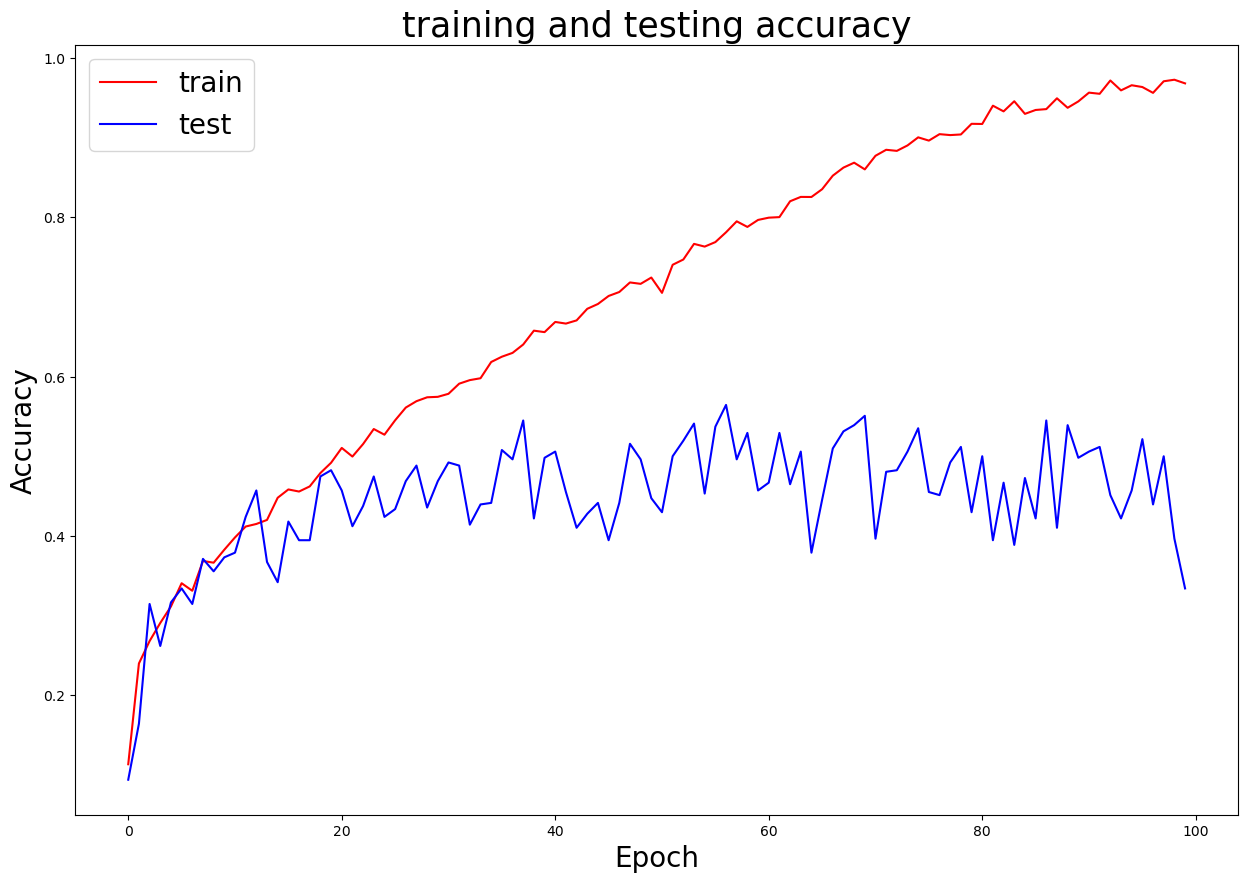

CPU times: total: 16.4 s
Wall time: 29.1 s


In [353]:
%%time
epoch_array = []
train_loss_array = []
test_loss_array = []
train_history = []
test_history = []
history1, history2 = Train(epochs, Model, train_dl, test_dl, optimizer, epoch_array , train_loss_array, test_loss_array, train_best_acc, test_best_acc)
train_history += history1
test_history += history2

train_loss_list = []
test_loss_list = []
train_acc_list = []
test_acc_list = []

def plot_lr_curve(train, test):
    plt.figure(figsize = (15, 10))
    plt.title("training and testing loss", fontsize = 25)
    plt.plot(train, color = "red", label = "train")
    plt.plot(test, color = "blue", label = "test")
    plt.xlabel("Epoch", fontsize = 20)
    plt.ylabel("Loss", fontsize = 20)
    plt.legend(loc = "best", fontsize="20")
    plt.show()

def plot_acc_curve(train, test):
    plt.figure(figsize = (15, 10))
    plt.title("training and testing accuracy", fontsize = 25)
    plt.plot(train, color = "red", label = "train")
    plt.plot(test, color = "blue", label = "test")
    plt.xlabel("Epoch", fontsize = 20)
    plt.ylabel("Accuracy", fontsize = 20)
    plt.legend(loc = "best", fontsize="20")
    plt.show()

for i in range(len(train_history)):
    # train_loss_list.append(train_history[i]["train_loss"].item())
    train_loss_list.append(train_loss_array[i])
    test_loss_list.append(test_history[i]["test_loss"].item())
    # train_acc_list.append(train_history[i]["train_acc"].item())
    train_acc_list.append(test_loss_array[i])
    test_acc_list.append(test_history[i]["test_acc"].item())

plot_lr_curve(train_loss_list, test_loss_list)
print()
plot_acc_curve(train_acc_list, test_acc_list)

## 2.(a) Construct a ResNet with residual blocks for image recognition and plot the learning curve, accuracy rate.

Best train acc:  1.0
Best test acc:  0.44140625


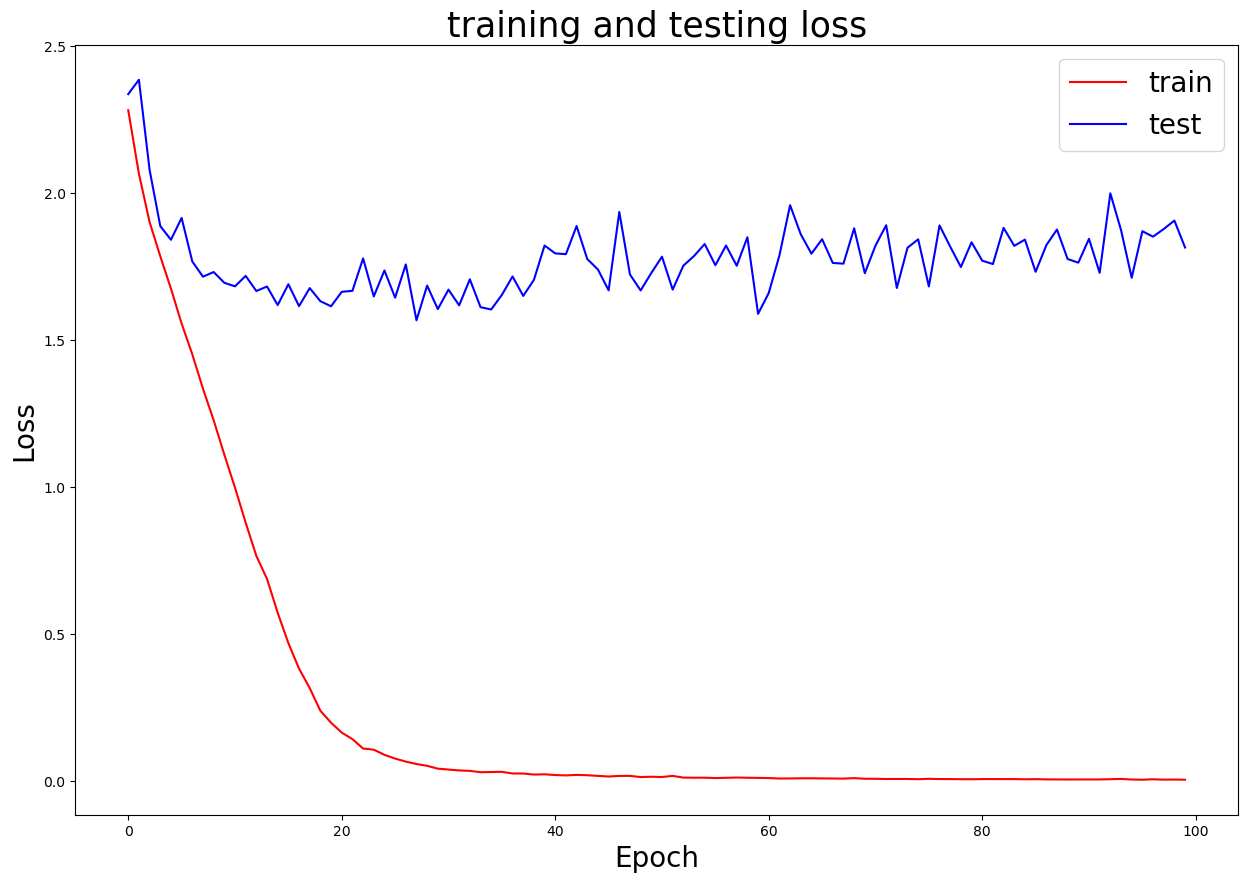

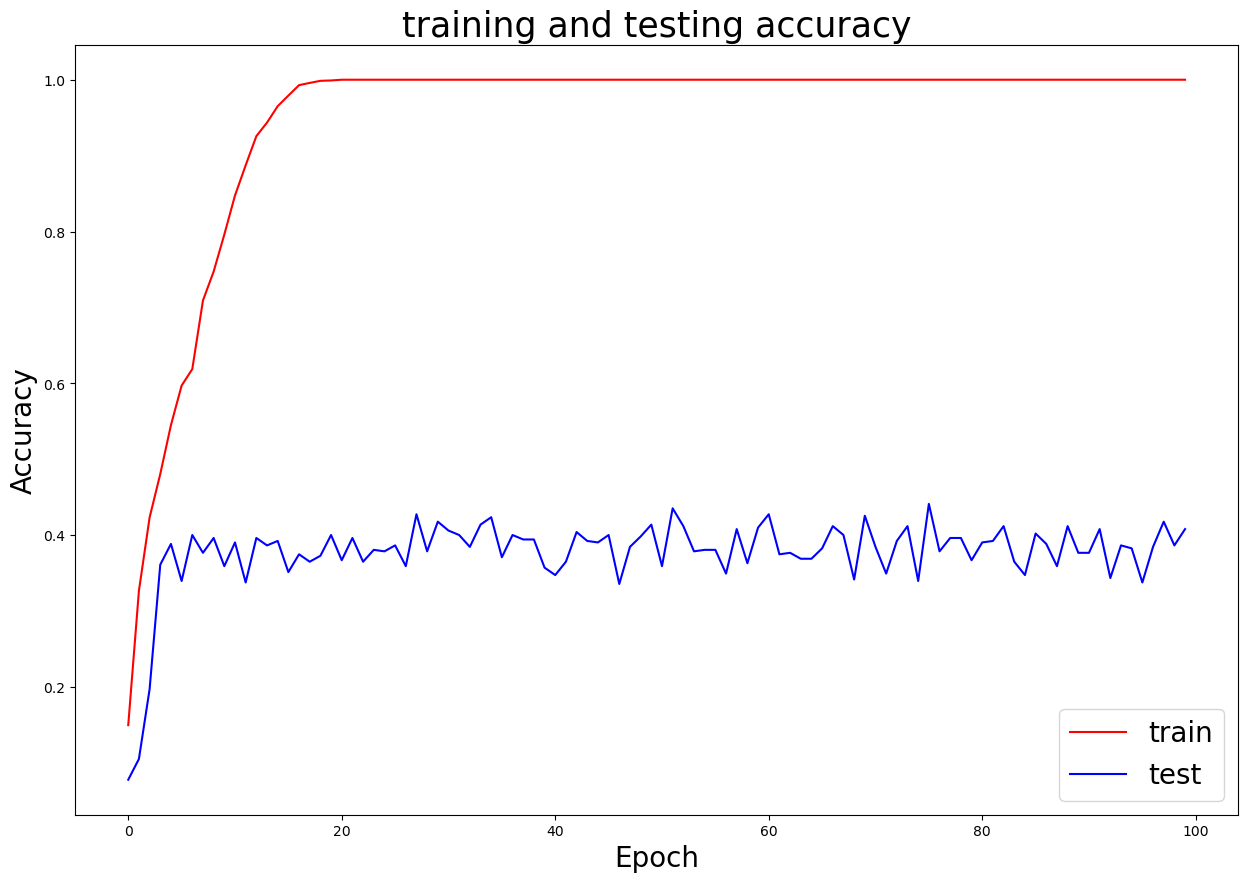

CPU times: total: 4min 27s
Wall time: 6min 16s


In [354]:
%%time
epoch_array18 = []
train_loss_array18 = []
test_loss_array18 = []
train_history18 = []
test_history18 = []

""" Set Confict """
Model_ResNet18 = to_device(ResNet18(), device)
epoch18 = 100
max_lr18 = 0.01
train_best_acc18 = 0.
test_best_acc18 = 0.
optimizer18 = torch.optim.SGD(params = Model_ResNet18.parameters(), lr = max_lr, momentum = 0.8, weight_decay = 5e-4)

history3, history4 = Train(epoch18, Model_ResNet18, train_dl, test_dl, optimizer18, epoch_array18 , train_loss_array18, test_loss_array18, train_best_acc18, test_best_acc18)
train_history18 += history3
test_history18 += history4

train_loss_list18 = []
test_loss_list18 = []
train_acc_list18 = []
test_acc_list18 = []

for i in range(len(train_history18)):
    # train_loss_list18.append(train_history18[i]["train_loss"].item())
    train_loss_list18.append(train_loss_array18[i])
    test_loss_list18.append(test_history18[i]["test_loss"].item())
    # train_acc_list18.append(train_history18[i]["train_acc"].item())
    train_acc_list18.append(test_loss_array18[i])
    test_acc_list18.append(test_history18[i]["test_acc"].item())

plot_lr_curve(train_loss_list18, test_loss_list18)
print()
plot_acc_curve(train_acc_list18, test_acc_list18)

## 2.(b) Remove the identity mapping and repeat (a)

Best train acc:  1.0
Best test acc:  0.40625


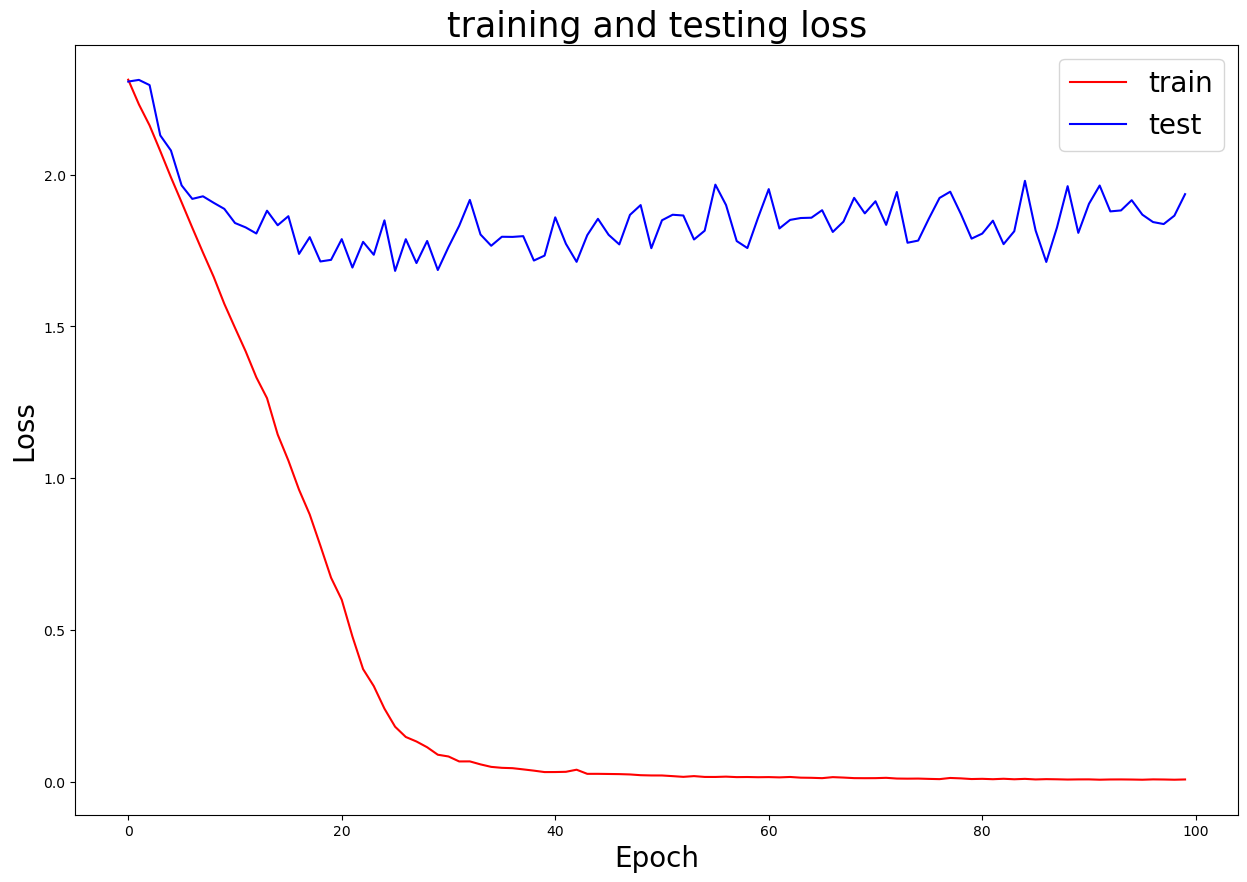

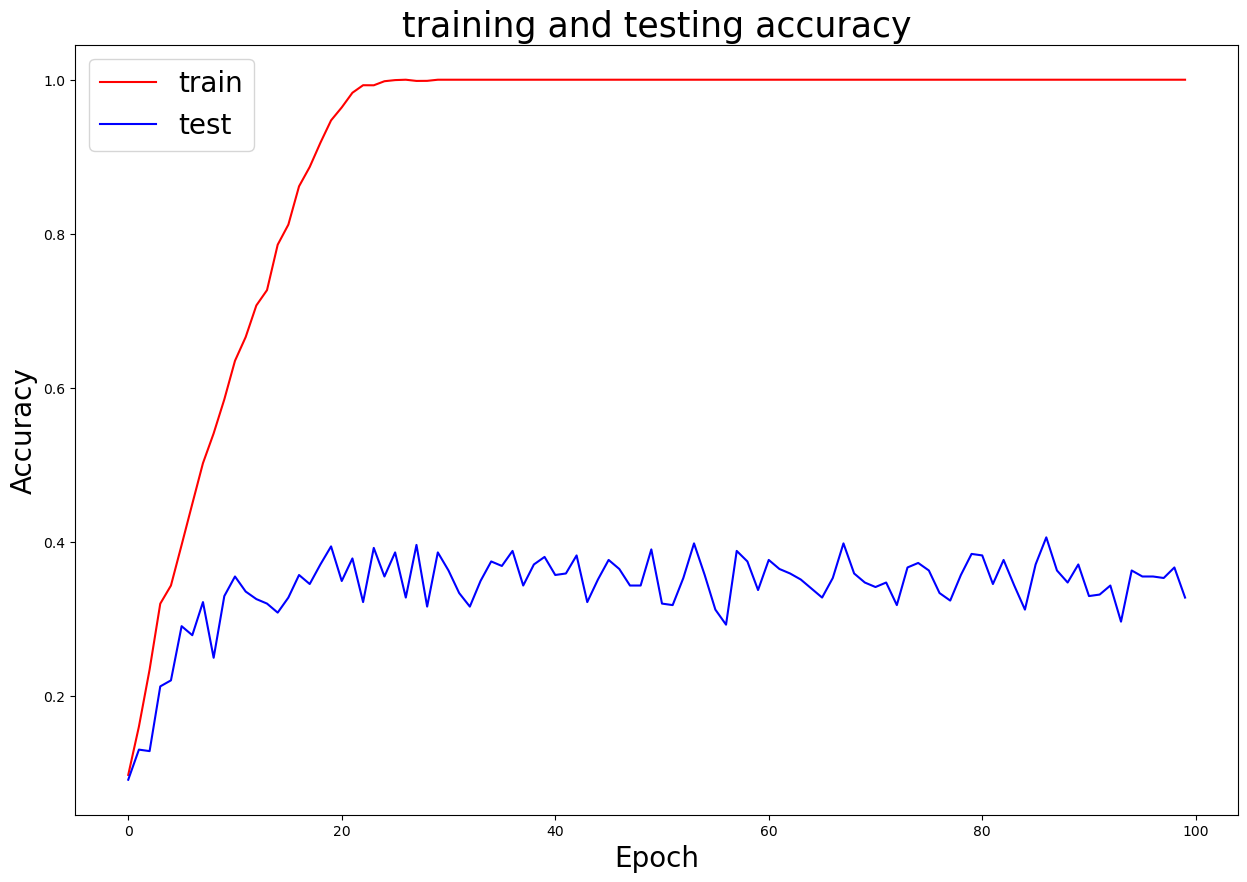

CPU times: total: 4min 12s
Wall time: 5min 44s


In [355]:
%%time
epoch_array18_i = []
train_loss_array18_i = []
test_loss_array18_i = []
train_history18_i = []
test_history18_i = []

""" Set Confict """
Identity = False
Model_ResNet18_wi = to_device(ResNet18(), device)
train_best_acc18_i = 0.
test_best_acc18_i = 0.
optimizer18_wi = torch.optim.SGD(params = Model_ResNet18_wi.parameters(), lr = max_lr, momentum = 0.8, weight_decay = 5e-4)

history5, history6 = Train(epoch18, Model_ResNet18_wi, train_dl, test_dl, optimizer18_wi, epoch_array18_i, train_loss_array18_i, test_loss_array18_i, train_best_acc18_i, test_best_acc18_i)
train_history18_i += history5
test_history18_i += history6

train_loss_list18_i = []
test_loss_list18_i = []
train_acc_list18_i = []
test_acc_list18_i = []

for i in range(len(train_history18_i)):
    # train_loss_list18_i.append(train_history18_i[i]["train_loss"].item())
    train_loss_list18_i.append(train_loss_array18_i[i])
    test_loss_list18_i.append(test_history18_i[i]["test_loss"].item())
    # train_acc_list18_i.append(train_history18_i[i]["train_acc"].item())
    train_acc_list18_i.append(test_loss_array18_i[i])
    test_acc_list18_i.append(test_history18_i[i]["test_acc"].item())

plot_lr_curve(train_loss_list18_i, test_loss_list18_i)
print()
plot_acc_curve(train_acc_list18_i, test_acc_list18_i)

## Make some discussion on the results of (a) and (b). Please describe what you found.

## Discussion:
在理論上如果增加神經網路的層數要能使其進行更深更複雜的特徵訓練進而得到更好的結果，但實際上部分知名神經網路架構如GoogleNet等會在增加層樹時遇到瓶頸，會遇上誤差不減反增的情形，其原因是由於梯度消失或爆炸所導致，進而使模型越深層越難訓練。而Identity的出現就是為了防止梯度下降或爆炸，能夠透過Identity選擇較優的進行學習。
從我們的結果中可以看出test accuracy上升到40%後會逐漸收斂，而loss則是會上下震盪，而是否有使用Identity的差別則在於上升至40%的速度，有使用Identity時會明顯較快上升至40%的準確率，而最終的test accuracy也是有使用Identity的略為好一些。